In [13]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [17]:
import os
import json
import glob
import pandas as pd
from pathlib import Path

def load_all_model_results():
    """Load all model fit results from the model_fits directory"""
    results = []
    
    # Find all JSON files in model_fits directory
    json_files = glob.glob("model_fits/**/*.json", recursive=True)

    
    
    for file_path in json_files:
        # if in filename "all_all", skip
        if "all" not in os.path.basename(file_path):
            continue
        try:
            with open(file_path, 'r') as f:
                result = json.load(f)
            
            # Extract participant ID and model type from filename if not in data
            filename = os.path.basename(file_path)
            parts = filename.replace('.json', '').split('_')
            #print(parts)
            if 'participantID' not in result:
                result['participantID'] = parts[0]

            
            result['modelType'] = parts[1]+"_"+parts[3]
            
            if parts[2]!="LapseFree":
                #print("Lapse fixed model, skipping")
                continue
            

            results.append(result)
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return results

# Load all results
all_results = load_all_model_results()
print(f"Loaded {len(all_results)} model fit results")

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(all_results)
print(f"Participants: {sorted(df_results['participantID'].unique())}")
print(f"Models: {sorted(df_results['modelType'].unique())}")


Loaded 8 model fit results
Participants: ['all']
Models: ['fusionOnlyLogNorm_sharedPrior', 'fusionOnly_sharedPrior', 'gaussian_sharedPrior', 'logLinearMismatch_sharedPrior', 'lognorm_sharedPrior', 'probabilityMatchingLogNorm_sharedPrior', 'selection_sharedPrior', 'switchingFree_sharedPrior']


In [ ]:
df_results

In [18]:
data, dataName = loadData.loadData("as_all.csv")
intensityVariable = "deltaDurS"
sensoryVar = "audNoise"
standardVar = "standardDur"
conflictVar = "conflictDur"
#s
visualStandardVar = "unbiasedVisualStandardDur"
visualTestVar = "unbiasedVisualTestDur"
audioStandardVar = "standardDur"
audioTestVar = "testDurS"
# Instantiate the Monte Carlo class
mc_fitter = monteCarloClass.OmerMonteCarlo(data)
print("Visual test duration range:", data["recordedDurVisualTest"].min(), "to", data["recordedDurVisualTest"].max())
# fit parameters
mc_fitter.nStart = 1 # Number of random starts for optimization
mc_fitter.nSimul = 100 # small number of simulations for quick test
mc_fitter.optimizationMethod= "bads"  # Use BADS for optimization
mc_fitter.modelName = "lognorm"  # Set measurement distribution to Gaussian
mc_fitter.integrationMethod = "analytical"  # Use numerical integration instead of analytical
mc_fitter.freeP_c = False  # Allow different prior widths for conflict conditions
mc_fitter.sharedLambda = False  # Use separate lapse rates for each condition
mc_fitter.dataName = dataName
#print("t_min, t_max:", mc_fitter.t_min, mc_fitter.t_max)


 Total trials before cleaning
: 2156
uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.5] 
 uniqueConflict: [np.float64(-0.25), np.float64(-0.17), np.float64(-0.08), np.float64(0.0), np.float64(0.08), np.float64(0.17), np.float64(0.25)]
total trials after cleaning: 2155
Visual test duration range: 0.1493 to 1.0912


In [19]:
participantIds=sorted(df_results['participantID'].unique())
modelTypes=sorted(df_results['modelType'].unique())
nParticipants=len(participantIds)
nModels=len(modelTypes)

import fitSaver
import os
participantID="as"
modelType="fusionOnlyLogNorm"

# simulate


In [20]:
participantIds=sorted(df_results['participantID'].unique())
modelTypes=sorted(df_results['modelType'].unique())
nParticipants=len(participantIds)
nModels=len(modelTypes)

import fitSaver
import os

def loadSimulatedData(mc_fitter, dataName,participantID, modelType=None):
    participantID = dataName.split(".csv")[0]
    #modelType = mc_fitter.modelName

    if mc_fitter.sharedLambda:
        modelType += "_LapseFix"
    else:
        modelType += "_LapseFree"

    if mc_fitter.freeP_c:
        modelType += "_contextualPrior"
    else:
        modelType += "_sharedPrior"

    filename = f"{participantID.split('_')[0]}_{modelType}_simulated.csv"
    filename = os.path.join("simulated_data",participantID.split('_')[0], filename)
    try:
        
        simulatedData= pd.read_csv(filename)
        print(f"Loaded saved simulated data from {filename}")
        return simulatedData
    except:
        print(f"No saved simulated data found at {filename}")
        fitSaver.saveSimulatedData(mc_fitter, mc_fitter.dataName)
        mc_fitter.simulatedData= pd.read_csv(filename)
        print(f"Simulated data saved to {filename}")
        return mc_fitter.simulatedData
#proceed to simulate and save to {filename}
# eg., mc_fitter.simulatedData=loadSimulatedData(mc_fitter, mc_fitter.dataName, participantID=dataName.split(".csv")[0], modelType=mc_fitter.modelName)

# for each participant load simulated data and fit to psychometric functions and save the fitted params in psychometric_fits_simulated/participantID/participantID_modelType_psychometricFits.json
# no need to plot for now, just save the fitted params
import monteCarloClass

def fitPsychometricFunctions2SimulatedData(participantIDs, modelTypes):
    for participantID in participantIds:
        for modelType in modelTypes:
            row = df_results[(df_results['participantID'] == participantID) & (df_results['modelType'] == modelType)]
            sharedPrior = 'sharedPrior' in modelType
            modelType=modelType.split("_")[0]
            print(f"Processing participant {participantID}, model {modelType}, sharedPrior: {sharedPrior}")
            if row.empty:
                print(f"No results found for participant {participantID} and model {modelType}, skipping.")
                continue
            result = row.iloc[0].to_dict()
            
            data,dataName=loadData.loadData(participantID+"_all.csv")
            # Initialize monteCarloClass with the model parameters
            tmp_mc_fitter = monteCarloClass.OmerMonteCarlo(data)
            tmp_mc_fitter.modelName = modelType
            tmp_mc_fitter.sharedLambda = 'LapseFix' in modelType
            tmp_mc_fitter.freeP_c = not sharedPrior
            tmp_mc_fitter.dataName = dataName

            
            simulatedData = loadSimulatedData(mc_fitter=tmp_mc_fitter, dataName=tmp_mc_fitter.dataName,participantID=participantID, modelType=tmp_mc_fitter.modelName)
            simulatedData=  mc_fitter.simulateMonteCarloData(mc_fitter.modelFit, mc_fitter.data)
            tmp_mc_fitter.simulatedData = simulatedData
            tmp_mc_fitter.simDataFit=tmp_mc_fitter.fitMultipleStartingPoints(tmp_mc_fitter.simulatedData,1)
            # save to psychometric_fits_simulated/participantID/participantID_modelType_psychometricFits.json without fitSaver function
            save_dir = os.path.join("psychometric_fits_simulated", participantID.split('_')[0])
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f"{participantID}_{modelType}_psychometricFits.json")
            print(f"Saving psychometric fits for simulated data to {save_path}")
            fit_data = {
                'participantID': participantID,
                'modelType': modelType,
                'fitParams': tmp_mc_fitter.simDataFit.x.tolist(),  # Convert ndarray to list
            }
            # serialize to json
            with open(save_path, 'w') as f:
                json.dump(fit_data, f)




fitPsychometricFunctions2SimulatedData(participantIds, modelTypes)


        
        
def fitPsychometric2RealData(participantIDs):
    for participantID in participantIds:
        row = df_results[(df_results['participantID'] == participantID)]
        print(f"Processing participant {participantID}")
        if row.empty:
            print(f"No results found for participant {participantID}, skipping.")
            continue
        result = row.iloc[0].to_dict()
        
        data,dataName=loadData.loadData(participantID+"_all.csv")
        # Initialize monteCarloClass with the model parameters
        tmp_mc_fitter = monteCarloClass.OmerMonteCarlo(data)

        tmp_mc_fitter.freeP_c = 1
        tmp_mc_fitter.dataName = dataName

        
        tmp_mc_fitter.realDataFit=tmp_mc_fitter.fitMultipleStartingPoints(tmp_mc_fitter.data,1)
        # save to psychometric_fits_real/participantID/participantID_modelType_psychometricFits.json without fitSaver function
        save_dir = os.path.join("psychometric_fits_real", participantID.split('_')[0])
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"{participantID}_psychometricFits.json")
        print(f"Saving psychometric fits for real data to {save_path}")
        fit_data = {
            'participantID': participantID,
            'fitParams': tmp_mc_fitter.realDataFit.x.tolist(),  # Convert ndarray to list
        }
        # serialize to json
        with open(save_path, 'w') as f:
            json.dump(fit_data, f)

        



#fitPsychometric2RealData(participantIds)
   

Processing participant all, model fusionOnlyLogNorm, sharedPrior: True

 Total trials before cleaning
: 28267
uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.5] 
 uniqueConflict: [np.float64(-0.25), np.float64(-0.17), np.float64(-0.08), np.float64(0.0), np.float64(0.08), np.float64(0.17), np.float64(0.25)]
total trials after cleaning: 23512
Loaded saved simulated data from simulated_data/all/all_fusionOnlyLogNorm_LapseFree_sharedPrior_simulated.csv
Saving psychometric fits for simulated data to psychometric_fits_simulated/all/all_fusionOnlyLogNorm_psychometricFits.json
Processing participant all, model fusionOnly, sharedPrior: True

 Total trials before cleaning
: 28267
uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.5] 
 uniqueConflict: [np.float64(-0.25), np.float64(-0.17), np.float64(-0.08), np.float64(0.0), np.float64(0.08), np.float64(0.17), np.float64(0.25)]
total trials after cleaning: 23512
Loaded saved simulated data from simulated_data/all/all_fusionOnly_LapseFree_sharedPrior_sim

In [4]:
df_results

,participantID,modelType,fittedParams,AIC,BIC,logLikelihood,n_conditions
0,sx,switchingFree_sharedPrior,"[0.0010000761032104288, 0.0684153325366973, 0....",2141.076250,2175.526452,-1062.538125,548
1,sx,lognorm_sharedPrior,"[0.010827709444374759, 0.2970975477012458, 0.3...",2155.071194,2185.215121,-1070.535597,548
2,sx,logLinearMismatch_sharedPrior,"[0.032859806000393364, 0.2476851209303061, 0.2...",2173.184572,2203.328499,-1079.592286,548
3,sx,fusionOnly_sharedPrior,"[0.022887993079794316, 0.153758934479332, 0.16...",2152.265325,2177.811330,-1070.132662,522
4,sx,fusionOnlyLogNorm_sharedPrior,"[0.001000086629595498, 0.30521380870952497, 0....",2149.645484,2175.483135,-1068.822742,548
...,...,...,...,...,...,...,...
135,ip,switching_sharedPrior,"[0.27314112638435994, 0.10224985842073724, 0.2...",2463.951618,2501.756200,-1222.975809,493
136,ip,gaussian_sharedPrior,"[0.18700045776458166, 0.13105093065150072, 0.2...",2473.681472,2503.085036,-1229.840736,493
137,ip,logLinearMismatch_sharedPrior,"[0.1911488932291989, 0.19594522194790084, 0.89...",2412.412694,2441.816258,-1199.206347,493
138,ip,fusionOnlyLogNorm_sharedPrior,"[0.13788956496247556, 0.23585898570927377, 1.1...",2404.078456,2429.281511,-1196.039228,493


In [14]:
participantIds
modelTypes

['fusionOnlyLogNorm_sharedPrior',
 'fusionOnly_sharedPrior',
 'gaussian_sharedPrior',
 'logLinearMismatch_sharedPrior',
 'lognorm_sharedPrior',
 'probabilityMatchingLogNorm_sharedPrior',
 'probabilityMatching_sharedPrior',
 'selection_sharedPrior',
 'switchingFree_sharedPrior',
 'switchingWithConflict_sharedPrior',
 'switching_sharedPrior']

In [10]:
data, dataName = loadData.loadData("dt_all.csv")
intensityVariable = "deltaDurS"
sensoryVar = "audNoise"
standardVar = "standardDur"
conflictVar = "conflictDur"
#s
visualStandardVar = "unbiasedVisualStandardDur"
visualTestVar = "unbiasedVisualTestDur"
audioStandardVar = "standardDur"
audioTestVar = "testDurS"
# Instantiate the Monte Carlo class
mc_fitter = monteCarloClass.OmerMonteCarlo(data)
print("Visual test duration range:", data["recordedDurVisualTest"].min(), "to", data["recordedDurVisualTest"].max())
# fit parameters
mc_fitter.nStart = 1 # Number of random starts for optimization
mc_fitter.nSimul = 100 # small number of simulations for quick test
mc_fitter.optimizationMethod= "bads"  # Use BADS for optimization
mc_fitter.modelName = "lognorm"  # Set measurement distribution to Gaussian
mc_fitter.integrationMethod = "analytical"  # Use numerical integration instead of analytical
mc_fitter.freeP_c = False  # Allow different prior widths for conflict conditions
mc_fitter.sharedLambda = False  # Use separate lapse rates for each condition
mc_fitter.dataName = dataName
#print("t_min, t_max:", mc_fitter.t_min, mc_fitter.t_max)


 Total trials before cleaning
: 2226
uniqueSensory: [0.1 1.2] 
 uniqueStandard: [0.5] 
 uniqueConflict: [np.float64(-0.25), np.float64(-0.17), np.float64(-0.08), np.float64(0.0), np.float64(0.08), np.float64(0.17), np.float64(0.25)]
total trials after cleaning: 2226
Visual test duration range: 0.0244 to 0.8007


Loaded real data psychometric fit for all from psychometric_fits_real/all/all_psychometricFits.json
Loaded simulated data psychometric fit for all, model lognorm from psychometric_fits_simulated/all/all_lognorm_psychometricFits.json✅
Loaded bootstrapped params for all from [[0.15490024051066983, 0.11564229513102894, 0.22677438338911235, 0.23816380003204854, 0.14165579560573657, -0.14256047162277488, -0.09307901619579698, 0.0018335565606463226, 0.05175493317286477, 0.12788917471551436, 0.11188724236326147, 0.14292938826731183, -0.04220026196296967, -0.010087208743167793, 0.02538187239074752, 0.014476659471058114, 0.027658306797569858, 0.05379507963348466, 0.05421293890014178], [0.10719898470124282, 0.1255414334017411, 0.21783893741409271, 0.24445557687998543, 0.14534788462410597, -0.12995100776281815, -0.09970113012538785, -0.008488975853092618, 0.043754620219707004, 0.10502465161238511, 0.12477388614784472, 0.14663843704966603, -0.047010268637388206, -0.020066711325048565, 0.0216184132

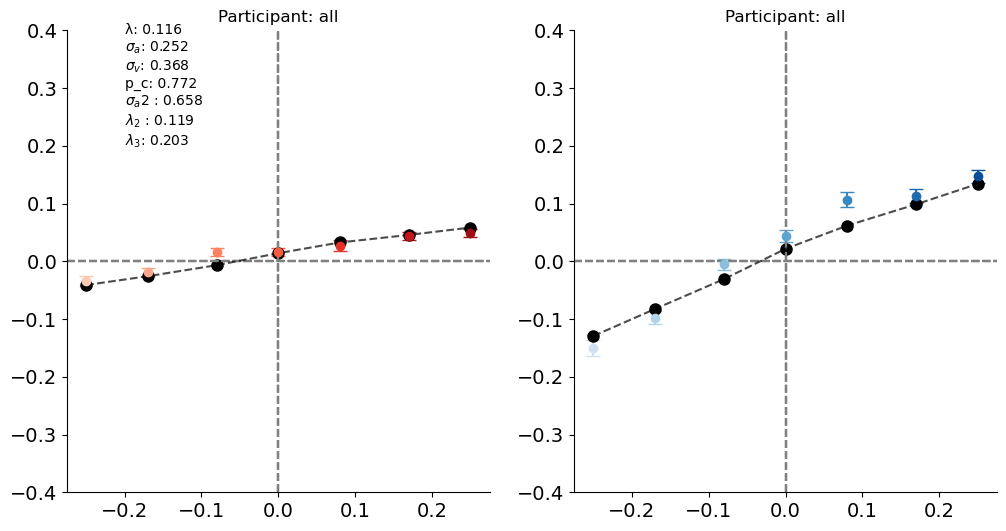

In [21]:
# import bootstrapperSaveLoad functions
import matplotlib.pyplot as plt
from bootstrapperSaveLoad import saveBootstrappedParams, loadBootstrappedParams
import loadResults
import os
import json
import seaborn as sns
lenSubjs=len(participantIds)
lenModels=len(modelTypes)
plt.figure(figsize=(12,6*lenSubjs))
for pNum,participantID in enumerate(participantIds):
    
    for modelType in ["lognorm"]:#modelTypes:


        modelType=modelType.split("_")[0]
        # 1- read psychometric fits for real data
        real_fit_path = os.path.join("psychometric_fits_real", participantID.split('_')[0], f"{participantID}_psychometricFits.json")
        try:
            with open(real_fit_path, 'r') as f:
                real_fit = json.load(f)
            print(f"Loaded real data psychometric fit for {participantID} from {real_fit_path}")
        except Exception as e:
            print(f"Error loading real data psychometric fit for {participantID}: {e}")
            continue

        # 2- read psychometric fits for simulated data
        sim_fit_path = os.path.join("psychometric_fits_simulated", participantID.split('_')[0], f"{participantID}_{modelType}_psychometricFits.json")
        try:
            with open(sim_fit_path, 'r') as f:
                sim_fit = json.load(f)
            print(f"Loaded simulated data psychometric fit for {participantID}, model {modelType} from {sim_fit_path}✅")
#            print(f"Simulated fit params: {sim_fit['fitParams']}")
        except Exception as e:
            print(f"Error loading simulated data psychometric fit for {participantID}, model {modelType}: {e}\n❗")
            continue
        
        # 3 - Read the bootsterapped fits for real data
        bootPath=participantID+"_dataFit_bootstrapped_params.json"
        dataBootsPath=os.path.join("bootstrapped_params", participantID.split('_')[0], bootPath)
        try:
            with open(dataBootsPath, 'r') as f:
                content=f.read().strip()
                dataBoots=json.loads(content) if content else {}
            print(f"Loaded bootstrapped params for {participantID} from {dataBoots}")
        except Exception as e:
            print(f"Error loading bootstrapped params for {participantID} from {dataBoots}: {e}\n❗")
            continue

        # 4 - read monte carlo fit results
        # 4.1 read data
        data, dataName = loadData.loadData(participantID+"_all.csv", verbose=False)
        mc_fitter = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter.modelName = modelType
        mc_fitter.freeP_c = False
        mc_fitter.sharedLambda = False
        mc_fitter.dataName = dataName 
        res=loadResults.loadFitResults(mc_fitter,dataName, modelName=mc_fitter.modelName)
        print(f"Loaded saved fit results: {res}")
        mc_fitter.modelFit= res['fittedParams']
        mc_fitter.logLikelihood= res['logLikelihood']
        mc_fitter.aic= res['AIC']
        mc_fitter.bic= res['BIC']
        mc_fitter.nDataPoints= res['n_conditions']

        # plt.text(-1,0.4,f" Subj: {participantID},  Model: {modelType}")
        # for i in range(len(mc_fitter.modelFit)):
        #     plt.text(-1,0.35-(i*0.05),f" Param {i}: {mc_fitter.modelFit[i]:.4f}")
        # proceed to plot all fits together
        for j, audioNoiseLevel in enumerate(sorted(mc_fitter.uniqueSensory)):
            conflict_levels = []
            mu_models=[]
                # also plot mc_fitter.modelFit as a text on the plot getParamsCausal 
            plt.subplot(lenSubjs,2 ,(pNum*2)+(j+1))
            if j==0:
                #plt.text(0.05, 0.9-(k*0.05), f"Conflict: {conflictLevel}ms", transform=plt.gca().transAxes, fontsize=10)
                plt.text(-0.2, 0.2,
                        f"λ: {mc_fitter.modelFit[0]:.3f}\n" +
                        f"$\sigma_a$: {mc_fitter.modelFit[1]:.3f}\n" +
                            f"$\sigma_v$: {mc_fitter.modelFit[2]:.3f}\n" +
                            f"p_c: {mc_fitter.modelFit[3]:.3f}\n" +
                            f"$\sigma_a2$ : {mc_fitter.modelFit[4]:.3f}\n"+
                            f"$\lambda_2$ : {mc_fitter.modelFit[5]:.3f}\n"+
                            f"$\lambda_3$: {mc_fitter.modelFit[6]:.3f}",

                )
                
            for k, conflictLevel in enumerate(mc_fitter.uniqueConflict):
                    
            

                conflict_levels.append(conflictLevel)
                plt.subplot(lenSubjs,2 ,(pNum*2)+(j+1))
                plt.title(f"Participant: {participantID}")
                color = sns.color_palette("viridis", as_cmap=True)(k / len(mc_fitter.uniqueConflict))
                
                for boot in dataBoots:
                    paramsBootDf = mc_fitter.getParams(boot, conflictLevel, audioNoiseLevel)  # lambda mu sigma
           
                    #plt.scatter(conflictLevel, muBoot, color=color, s=10, alpha=0.1)
                # plot bootstrap mean
                bootMus = [mc_fitter.getParams(boot, conflictLevel, audioNoiseLevel)[1] for boot in dataBoots]
                print(f"length of parameters boots: {len(bootMus)}")
                print(f"Conflict Level: {conflictLevel}, mu boots: {bootMus}")

                if audioNoiseLevel == 0.1:
                    color = sns.color_palette("Reds", as_cmap=True)(0.2 + 0.8 * (k / len(mc_fitter.uniqueConflict)))
                elif audioNoiseLevel == 1.2:
                    color = sns.color_palette("Blues", as_cmap=True)(0.2+ 0.8 * (k / len(mc_fitter.uniqueConflict)))

                plt.errorbar(conflictLevel, np.mean(bootMus), yerr=np.std(bootMus), color=color, fmt='o', capsize=5, alpha=1)
                
                paramsSimDf = mc_fitter.getParams(sim_fit['fitParams'], conflictLevel, audioNoiseLevel)  # lambda mu sigma

                muModel = paramsSimDf[1]
                #muData = self.getParams(self.dataFit.x, conflictLevel, audioNoiseLevel)[1]
                mu_models.append(muModel)


                plt.plot(conflictLevel, muModel, color="black",  alpha=1,linestyle='--',marker='o',markersize=8)
                #plt.xlabel(f"Conflict (ms)", fontsize=16)
                #plt.ylabel("PSE shift (ms)", fontsize=16)
                plt.axhline(y=0, color='gray', linestyle='--')
                plt.axvline(x=0, color='gray', linestyle='--')
                plt.ylim(-0.4, 0.4)
                #plt.title(f"{self.dataName} AV,A Duration Comp. Noise: {audioNoiseLevel}", fontsize=16)

                plt.xticks(fontsize=14)
                plt.yticks(fontsize=14)
                ax = plt.gca()
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                #ax.spines['bottom'].set_visible(False)

            # Convert lists to arrays and sort them for a proper line plot
            conflict_levels = np.array(conflict_levels)
            mu_models = np.array(mu_models)

            sorted_indices = np.argsort(conflict_levels)
            conflict_levels_sorted = conflict_levels[sorted_indices]
            mu_models_sorted = mu_models[sorted_indices]
            plt.plot(conflict_levels_sorted, mu_models_sorted, color="black", alpha=0.7, linestyle='--')
    
        
        




In [12]:
# Interactive plotting with model selection
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

def create_interactive_plot(selected_models,verbose=False):
    """Create plots for selected models"""
    if not selected_models:
        print("Please select at least one model to display")
        return
    
    def _print(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)
        
    with plot_output:
        clear_output(wait=True)
        
        lenSubjs = len(participantIds)
        fig, axes = plt.subplots(lenSubjs, 2, figsize=(12, 6*lenSubjs))
        if lenSubjs == 1:
            axes = axes.reshape(1, -1)
        
        for pNum, participantID in enumerate(participantIds):
            for modelType in selected_models:
                modelType_clean = modelType.split("_")[0]
                
                # 1- read psychometric fits for real data
                real_fit_path = os.path.join("psychometric_fits_real", participantID.split('_')[0], f"{participantID}_psychometricFits.json")
                try:
                    with open(real_fit_path, 'r') as f:
                        real_fit = json.load(f)
                    _print(f"Loaded real data psychometric fit for {participantID}")
                except Exception as e:
                    _print(f"Error loading real data psychometric fit for {participantID}: {e}")
                    continue

                # 2- read psychometric fits for simulated data
                sim_fit_path = os.path.join("psychometric_fits_simulated", participantID.split('_')[0], f"{participantID}_{modelType_clean}_psychometricFits.json")
                try:
                    with open(sim_fit_path, 'r') as f:
                        sim_fit = json.load(f)
                    _print(f"Loaded simulated data psychometric fit for {participantID}, model {modelType_clean}✅")
                except Exception as e:
                    _print(f"Error loading simulated data psychometric fit for {participantID}, model {modelType_clean}: {e}")
                    continue
                
                # 3 - Read the bootstrapped fits for real data
                bootPath = participantID + "_dataFit_bootstrapped_params.json"
                dataBootsPath = os.path.join("bootstrapped_params", participantID.split('_')[0], bootPath)
                try:
                    with open(dataBootsPath, 'r') as f:
                        content = f.read().strip()
                        dataBoots = json.loads(content) if content else {}
                    _print(f"Loaded bootstrapped params for {participantID}")
                except Exception as e:
                    _print(f"Error loading bootstrapped params for {participantID}: {e}")
                    continue

                # 4 - read monte carlo fit results
                data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
                mc_fitter = monteCarloClass.OmerMonteCarlo(data)
                mc_fitter.modelName = modelType_clean
                mc_fitter.freeP_c = False
                mc_fitter.sharedLambda = False
                mc_fitter.dataName = dataName 
                res = loadResults.loadFitResults(mc_fitter, dataName, modelName=mc_fitter.modelName)
                _print(f"Loaded saved fit results for {participantID}")
                mc_fitter.modelFit = res['fittedParams']
                mc_fitter.logLikelihood = res['logLikelihood']
                mc_fitter.aic = res['AIC']
                mc_fitter.bic = res['BIC']
                mc_fitter.nDataPoints = res['n_conditions']

                # Get model color (different color for each model)
                model_colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown']
                model_idx = selected_models.index(modelType) % len(model_colors)
                model_color = model_colors[model_idx]
                
                # proceed to plot all fits together
                for j, audioNoiseLevel in enumerate(sorted(mc_fitter.uniqueSensory)):
                    conflict_levels = []
                    mu_models = []

                    # Calculate baseline PSE at conflict == 0
                    baseline_pse = np.mean([mc_fitter.getParams(boot, 0, audioNoiseLevel)[1] for boot in dataBoots])
                    #print(f"Baseline PSE for participant {participantID}, audio noise {audioNoiseLevel}: {baseline_pse}")

                    
                    for k, conflictLevel in enumerate(mc_fitter.uniqueConflict):
                        conflict_levels.append(conflictLevel)
                        
                        # Select the correct subplot
                        if lenSubjs == 1:
                            ax = axes[j]
                        else:
                            ax = axes[pNum, j]
                        
                        plt.sca(ax)
                        
                        if modelType == selected_models[0]:  # Only set title and plot data for first model
                            ax.set_title(f"Participant: {participantID}, Audio Noise: {audioNoiseLevel}")
                            
                            # Plot bootstrap data (only once)
                            bootMus = [mc_fitter.getParams(boot, conflictLevel, audioNoiseLevel)[1] for boot in dataBoots]
                            bootMus = np.array(bootMus) - baseline_pse  # Center around baseline
                            if audioNoiseLevel == 0.1:
                                color = sns.color_palette("Reds", as_cmap=True)(0.2 + 0.8 * (k / len(mc_fitter.uniqueConflict)))
                            elif audioNoiseLevel == 1.2:
                                color = sns.color_palette("Blues", as_cmap=True)(0.2 + 0.8 * (k / len(mc_fitter.uniqueConflict)))
                            
                            ax.errorbar(conflictLevel, np.mean(bootMus), yerr=np.std(bootMus), 
                                      color=color, fmt='o', capsize=5, alpha=1, label='Data' if k == 0 else "")

                        # Plot model predictions
                        paramsSimDf = mc_fitter.getParams(sim_fit['fitParams'], conflictLevel, audioNoiseLevel)
                        muModel = paramsSimDf[1]
                        
                        # 
                        #print(f"Model {modelType}, fitted parameters are: {sim_fit['fitParams']}")

                        baseline_mu_model = mc_fitter.getParams(sim_fit['fitParams'], 0, audioNoiseLevel)[1]
                        muModel -= baseline_mu_model  # Center around model baseline
                        #muModel -= baseline_pse  # Center around baseline
                        mu_models.append(muModel)

                        ax.plot(conflictLevel, muModel, color=model_color, alpha=1, linestyle='--', 
                               marker='o', markersize=6, label=f'{modelType}' if k == 0 else "")
                        
                        # Set common plot properties (only for first model to avoid repetition)
                        if modelType == selected_models[0]:
                            ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
                            ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
                            ax.set_ylim(-0.35, 0.35)
                            ax.tick_params(axis='both', labelsize=12)
                            if pNum == lenSubjs - 1:  # Only add xlabel to bottom plots
                                ax.set_xlabel("Conflict (ms)", fontsize=14)
                            if j == 0:  # Only add ylabel to left plots
                                ax.set_ylabel("PSE shift (ms)", fontsize=14)

                    # Convert lists to arrays and sort them for a proper line plot
                    conflict_levels = np.array(conflict_levels)
                    mu_models = np.array(mu_models)
                    sorted_indices = np.argsort(conflict_levels)
                    conflict_levels_sorted = conflict_levels[sorted_indices]
                    mu_models_sorted = mu_models[sorted_indices]
                    
                    # Select the correct subplot for continuous line
                    if lenSubjs == 1:
                        ax = axes[j]
                    else:
                        ax = axes[pNum, j]
                    
                    ax.plot(conflict_levels_sorted, mu_models_sorted, color=model_color, alpha=0.7, linestyle='--')
        
        # Add legend to the first subplot
        if lenSubjs == 1:
            axes[0].legend(loc='upper right', fontsize=10)
        else:
            axes[0, 0].legend(loc='upper right', fontsize=10)
        
        plt.tight_layout()
        plt.show()

# Create model selection checkboxes
model_checkboxes = []
for model in modelTypes:
    checkbox = widgets.Checkbox(
        value=(model == "lognorm_sharedPrior"),  # Default to first model selected
        description=model,
        disabled=False,
        layout=widgets.Layout(width='200px')
    )
    model_checkboxes.append(checkbox)

# Create update button
update_button = widgets.Button(
    description='Update Plot',
    disabled=False,
    button_style='success',
    tooltip='Click to update the plot with selected models',
)

# Create output widget for the plot
plot_output = widgets.Output()

def on_button_click(b):
    selected_models = [checkbox.description for checkbox in model_checkboxes if checkbox.value]
    create_interactive_plot(selected_models)

update_button.on_click(on_button_click)

# Layout the widgets
checkbox_container = widgets.VBox(model_checkboxes)
control_panel = widgets.HBox([checkbox_container, widgets.VBox([update_button])])

print("Interactive Model Comparison Plot")
print("Select the models you want to compare and click 'Update Plot':")
display(control_panel)
display(plot_output)

# Initial plot with default selection
selected_models = [checkbox.description for checkbox in model_checkboxes if checkbox.value]
create_interactive_plot(selected_models)

ModuleNotFoundError: No module named 'ipywidgets'